In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os

# This notebook is to check difference between EPEC and Optimal System Cost

In [52]:
print("Loading results from:")
files_path = os.path.realpath(os.path.join(os.path.abspath(''), "Model_CSV"))
print("\t",files_path)
files_name = 'Model_data_DA_'
append_name ="_20221021-185407"
ncda = 9
#Model_data_DA_1_20221021-185407
data = []
for j in range(1,ncda+1):
    path = os.path.join(files_path,files_name+str(j)+append_name+'.csv')
    #print("Reading file {} : {}".format(j,path))
    data.append(pd.read_csv(path))

Loading results from:
	 D:\GitHub\PyomoModels\09_MPEC_Bidding_Diagonalization\MatlabCode\V06\ResultsAnalysis\Model_CSV


## Matlab optimal results

In [53]:
files_name = 'results_lin_comp_market_10-17-2022@20.41.xlsx'
lin_Competitive_Profit = pd.read_excel(files_name,'Competitive Profit', header=None)

## MPEC PROFIT / SYSTEM-COST: sum(Sell - Buy)*LMPs

In [54]:
da_loc = np.array([[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],
[1,1,1,0,0,0,0,0,0],
[0,0,0,1,1,1,0,0,0],
[0,0,0,0,0,0,1,1,1],
[0,0,0,0,0,0,0,0,0]])

bus_col = []
for i in range(1,7):
    bus_col.append('Bus'+str(i)+'_price')

MVA=30

bus_price = data[0][data[0].Iteration==1][bus_col].to_numpy().transpose()

da_sell_list=[]
for df in data:
    da_sell_list.append(df[df.Iteration==1]['DAs_generation\nE_DAs_G'].tolist())

da_buy_list=[]
for df in data:
    da_buy_list.append(df[df.Iteration==1]['DAs_load\nE_DAs_L'].tolist())

da_sell = np.array(da_sell_list)
da_buy  = np.array(da_buy_list)

price_mat = np.matmul(da_loc.T,bus_price)
amount_mat = da_sell*MVA-da_buy*MVA

Mpec_profit = np.multiply(amount_mat, price_mat)

In [55]:
def compute_DAs_Systemcost(iteration, DA_no):
    da_loc = np.array([[0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0],
            [0,0,0,1,1,1,0,0,0],
            [0,0,0,0,0,0,1,1,1],
            [0,0,0,0,0,0,0,0,0]])

    bus_col = []
    for i in range(1,7):
        bus_col.append('Bus'+str(i)+'_price')
    
    MVA=30

    bus_price = data[DA_no][data[DA_no].Iteration==iteration][bus_col].to_numpy().transpose()
    
    da_sell_list=[]
    for df in data:
        da_sell_list.append(df[df.Iteration==iteration]['DAs_generation\nE_DAs_G'].tolist())
        
    da_buy_list=[]
    for df in data:
        da_buy_list.append(df[df.Iteration==iteration]['DAs_load\nE_DAs_L'].tolist())
        
    da_sell = np.array(da_sell_list)
    da_buy  = np.array(da_buy_list)
    
    price_mat = np.matmul(da_loc.T,bus_price)
    amount_mat = da_sell*MVA-da_buy*MVA
    
    Mpec_profit = np.multiply(amount_mat, price_mat)
    
    return Mpec_profit

In [56]:
das_cost = []

for it in data[0].Iteration.unique():
    if it!=0:
        das_cost.append(pd.DataFrame(compute_DAs_Systemcost(it, 0)).sum().to_list())
        
das_cost = pd.DataFrame(das_cost)


In [57]:
time_dict = dict(list(enumerate([x for x in range(16,40)])))

def change_time(df):
    for x in range(16,40):
        if x >=24:
            index = df[df['Time'] == x].index
            df.loc[index,'Time'] = df.Time[index]%24
    return df

In [58]:
das_cost = das_cost.rename(columns=time_dict)
das_cost = das_cost.drop(index=0)

In [59]:
lin_Competitive_Profit = lin_Competitive_Profit.rename(columns=time_dict)

In [60]:
das_cost.sum(axis=1)

1      92413.959814
2     242303.144616
3     320344.889275
4     308395.701059
5     336091.872254
6     304895.976526
7     370194.375559
8     294688.228882
9     401989.713105
10    300868.173023
11    400557.747104
12    300694.618591
13    407636.286807
14    302361.955666
15    405500.266896
16    299265.192287
17    403918.395301
18    307877.021755
19    403704.422197
20    299718.737610
21    403700.270993
22    304307.392180
23    406609.032255
24    301537.173065
dtype: float64

In [48]:
lin_Competitive_Profit.sum().sum()

6314.264394602887

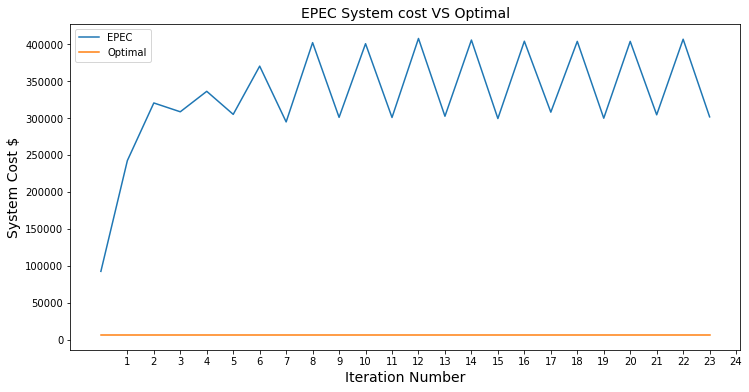

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
X=[ x for x in range(len(das_cost.sum(axis=1)))]
Y=das_cost.sum(axis=1)
line1, = axes.plot(X,Y, label="EPEC")
Y= [lin_Competitive_Profit.sum().sum() for x in range(len(das_cost.sum(axis=1)))]
line2, =axes.plot(X,Y, label="Optimal")

axes.legend([line1, line2], ["EPEC", "Optimal"])
axes.set_xticks([x+1 for x in range(len(das_cost.sum(axis=1)))]);
axes.set_xlabel("Iteration Number", fontsize=14)
axes.set_ylabel("System Cost $", fontsize=14)
axes.set_title("EPEC System cost VS Optimal", fontsize=14);